In [1]:
from qiskit import *
from qiskit.circuit.library import DraperQFTAdder, RGQFTMultiplier
from qiskit.quantum_info import Statevector, partial_trace
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor

from matplotlib.pyplot import figure

### 2 bit Adder Circuit

In [3]:
# Enter values to be added
a_val = 1
b_val = 1

a = QuantumRegister(1, 'a')
b = QuantumRegister(1, 'b')
c = QuantumRegister(1, 'c')
cl = ClassicalRegister(2)

two_bit_adder = QuantumCircuit(a, b, c, cl)

state_1 = Statevector.from_int(1, 2**1) # if dims (2nd arg) == 2**n n qubit state is initialised
state_2 = Statevector.from_int(1, 2**1)

two_bit_adder.initialize(state_1, 0)
two_bit_adder.initialize(state_2, 1)
two_bit_adder.reset(c) # unnecessary but to ensure c qubit is set to |0> state before addition
two_bit_adder.barrier()

two_bit_adder.ccx(a, b, c) # and gate ==> toffoli gate
two_bit_adder.cx(a, b) # xor gate ==> cx gate

two_bit_adder.barrier()

# to run on a quantum computer
two_bit_adder.measure(range(1,3), range(2))

two_bit_adder.draw('mpl').savefig('classical.jpg')

In [4]:
# state_1 = Statevector.from_int(0, 2**1) # if dims (2nd arg) == 2**n n qubit state is initialised
# state_2 = Statevector.from_int(1, 2**1)
# state_3 = Statevector.from_int(0, 2**1)

# state_in = state_1.expand(state_2).expand(state_3) # |1> |2> |3>

# state_in.draw('latex')

# state_out = state_in.evolve(two_bit_adder)
# state_out2 = partial_trace(state_out, [0])
# print(state_out.probabilities_dict())
# print(state_out2.probabilities_dict())

# Simulation


simulator = Aer.get_backend('aer_simulator')

provider = IBMProvider()
backend = provider.get_backend('ibmq_qasm_simulator')

job = backend.run(two_bit_adder)
job_monitor(job)

Job Status: job has successfully run


{2: 1.0}


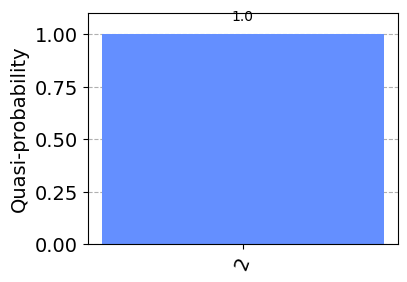

In [5]:
num_shots = 4000 # for cloud simulator
counts = job.result().get_counts(two_bit_adder)
counts = {int(key, 2): value / num_shots for key, value in counts.items()}
print(counts)
plot_histogram(counts, figsize=(4,3))

In [6]:
def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val                         # return positive value as is

### Draper Addition operator

In [7]:
draper_adder = QuantumCircuit(4)
gate = DraperQFTAdder(2, kind='fixed', name='adder')

draper_adder.append(gate, range(4))

In [8]:
state_a = Statevector.from_int(-1, 2**2)
state_b = Statevector.from_int(2, 2**2)
state_c = Statevector.from_int(0, 2**1)

state = state_a.tensor(state_b)
state = state.tensor(state_c)

state.draw('latex')

<IPython.core.display.Latex object>

In [9]:
# Draper Addition fixed --> (x + y) mod(2**num_qubits)

a_val = -3
b_val = +3

num_qubits = 4
draper_adder = DraperQFTAdder(num_qubits, kind='fixed', name='draper+')

x = Statevector.from_int(-3, 2**num_qubits)
y = Statevector.from_int(2, 2**num_qubits)
# z = Statevector.from_int(0, 2**num_qubits)
initial_state = x.tensor(y)
final_state = initial_state.evolve(draper_adder)
final_state_traced = partial_trace(final_state, list(range(num_qubits)))
s = final_state_traced.probabilities_dict(decimals=4)

print(draper_adder.draw(reverse_bits=True))
print({int(k, 2): v for k, v in s.items()})

     ┌──────────┐
b_3: ┤7         ├
     │          │
b_2: ┤6         ├
     │          │
b_1: ┤5         ├
     │          │
b_0: ┤4         ├
     │  draper+ │
a_3: ┤3         ├
     │          │
a_2: ┤2         ├
     │          │
a_1: ┤1         ├
     │          │
a_0: ┤0         ├
     └──────────┘
{15: 1.0}


In [10]:
print(s)
binary_fixed = list(s.keys())[0]
# binary_string = '11111'
print(twos_comp(int(binary_fixed,2), len(binary_fixed)))

{'1111': 1.0}
-1


In [14]:
# draper addition half
num_qubits = 2
draper_adder = DraperQFTAdder(num_qubits, kind='half', name='draper+')

x = Statevector.from_int(-3, 2**num_qubits)
y = Statevector.from_int(2, 2**num_qubits)
z = Statevector.from_int(0, 2**1)
initial_state = z.tensor(y).tensor(x)
final_state = initial_state.evolve(draper_adder)
final_state_traced = partial_trace(final_state, list(range(num_qubits)))
s = final_state_traced.probabilities_dict(decimals=4)

fig = draper_adder.decompose().draw('mpl')
fig.savefig('adder.jpg')

In [45]:
print({int(k, 2): v for k, v in s.items()})
print(s)

{15: 1.0}
{'01111': 1.0}


In [46]:
binary_string = list(s.keys())[0]
# binary_string = '11111'
print(twos_comp(int(binary_string,2), len(binary_string)))

15


In [68]:
bbb = bin(-3)
bin((-1 << 4)-1 & -5)
print(bbb)

-0b11


In [69]:
twos_comp(int(bbb,2), len(bbb))

-35

## Perez QFT multiplier - out of place mult - total = 4 * no. of qubits for single num

In [32]:
num_qubits = 2
multiplier = RGQFTMultiplier(num_qubits, name='QFT multi')

x = Statevector.from_int(1, 2**num_qubits)
y = Statevector.from_int(0, 2**num_qubits)
z = Statevector.from_int(0, 2**(2*num_qubits))
initial_state_m = z.tensor(y).tensor(x)
final_state_m = initial_state_m.evolve(multiplier)
final_state_traced_m = partial_trace(final_state_m, list(range(2*num_qubits)))
s_mul = final_state_traced_m.probabilities_dict(decimals=4)

fig2 = multiplier.decompose().draw('mpl', fold=14)
fig2.savefig('multiplier.jpg')

In [40]:
print({int(k, 2): v for k, v in s_mul.items()})
print(s_mul)

{42: 1.0}
{'0000101010': 1.0}
